In [27]:
import math
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt

In [28]:
#Função Sphere
def sphere(vetor, limite_inferior=-100, limite_superior=100):
  resultado = 0
  
  for i in vetor:
    resultado += i**2
  
  return resultado

#Função rastrigin
def rastrigin(vetor, limite_inferior=-30, limite_superior=30):
  resultado = 0
  
  for i in vetor:
    x = 2*math.pi*i
    resultado += 10 + ((i**2) - 10 * math.cos(x))
    

  return resultado 

#Função rosenbrock
def rosenbrock(vetor, limite_inferior=-5.12, limite_superior=5.12):
  resultado = 0
  
  for i in range(0,(len(vetor)-1)):
    resultado += 100*(vetor[i+1] - vetor[i]**2)**2 + (vetor[i] - 1)**2
    
  return resultado

In [29]:
class FonteAlimentacao:
    def __init__(self, funcao, posicao=None, limite_inferior=None, limite_superior=None, dimensao=None, qtd_tentativas=None):
        self.posicao = np.array(posicao) if posicao is not None else np.random.uniform(low=limite_inferior, high=limite_superior, size=dimensao)
        self.qtd_tentativas = qtd_tentativas
        self.fitness = funcao(self.posicao)


In [30]:
class Abelha():
    def __init__(self, funcao, posicao):
        self.posicao = posicao
        self.fitness = funcao(posicao)

In [31]:
# E se no cálculo de posição para a abelha, o valor sair dos limites do espaço de busca? Tem que ter sim!! Precisamos puxá-las para a borda.
# Criar classes separadas as fontes e para as abelhas
# Tirar a função fitness do cálculo a fim de que seja acessível sem tanto custo computacional

class AlgoritmoColoniaAbelhas:
    def __init__(self, funcao, limite_inferior, limite_superior, qtd_ciclos, tamanho_colonia, dimensao, fator_abandono):
        self.funcao = funcao
        self.limite_inferior = limite_inferior
        self.limite_superior = limite_superior
        self.qtd_ciclos = qtd_ciclos
        self.tamanho_colonia = tamanho_colonia
        self.dimensao = dimensao
        self.fator_abandono = fator_abandono
        self.fitness_fontes = []
        self.fontes_alimentacao = self.criar_fontes_alimentacao(tamanho_colonia//2)
        self.abelhas_empregadas = []
        self.abelhas_observadoras = []
        self.historico_fitness = []
        self.melhor_global = float('inf')
        self.melhor_fonte_global = None

    def criar_fontes_alimentacao(self, qtd_fontes):
        fontes = []
        for i in range(qtd_fontes):
            nova_fonte = FonteAlimentacao(funcao=self.funcao, limite_inferior=self.limite_inferior, limite_superior=self.limite_superior, dimensao=self.dimensao, qtd_tentativas=0)
            fontes.append(nova_fonte)
            self.fitness_fontes.append(nova_fonte.fitness)
        return fontes

    def guardar_fitness_ciclo(self, fontes_alimentacao):
        for indice, fonte in enumerate(fontes_alimentacao):
            self.fitness_fontes[indice] = fonte.fitness

    def calcular_fitness(self, vetor):
        return self.funcao(vetor)
    
    def realizar_ciclo(self):
        for ciclo in range(self.qtd_ciclos):
            self.atribuir_posicao_empregadas(ciclo, self.tamanho_colonia//2)
            self.atribuir_posicao_observadoras(self.fitness_fontes)
            self.atribuir_posicao_exploradoras()
            self.guardar_fitness_ciclo(self.fontes_alimentacao)
            melhor_fitness_iteracao = np.min(self.fitness_fontes)
            indice_melhor_fitness = np.argmin(self.fitness_fontes)
            if melhor_fitness_iteracao < self.melhor_global:
                self.melhor_global = melhor_fitness_iteracao
                self.melhor_fonte_global = self.fontes_alimentacao[indice_melhor_fitness].posicao.copy()
            self.historico_fitness.append(melhor_fitness_iteracao)
            if ciclo == 0 or ciclo == self.qtd_ciclos - 1:
                print(f"Geração {ciclo+1} | Melhor solução: {self.melhor_fonte_global} | Fitness: {np.min(self.historico_fitness)} | Histórico Fitness: {self.historico_fitness}")
            
    def atribuir_posicao_empregadas(self, numero_ciclo, qtd_abelhas):
        if numero_ciclo == 0:
            for i in range(qtd_abelhas):
                self.abelhas_empregadas.append(Abelha(self.funcao, self.fontes_alimentacao[i].posicao))
        self.abelhas_empregadas = self.atualizar_posicao(self.abelhas_empregadas)

    def atribuir_posicao_observadoras(self, fitness):
        total_fitness_invertido = np.sum([1 / fitness[i] for i in range(self.tamanho_colonia // 2)])
        proporcoes_fitness = []
        self.abelhas_observadoras = [] 
        for i in range(self.tamanho_colonia // 2):
            proporcoes_fitness.append(1 / fitness[i] / total_fitness_invertido)
        for i in range(self.tamanho_colonia // 2):
            probabilidade_random = np.random.rand()
            probabilidade_acumulativa = 0
            for fonte, proporcao in zip(self.fontes_alimentacao, proporcoes_fitness):
                probabilidade_acumulativa += proporcao
                if probabilidade_random <= probabilidade_acumulativa:
                    self.abelhas_observadoras.append(Abelha(self.funcao, fonte.posicao))
                    break
        self.abelhas_observadoras = self.atualizar_posicao(self.abelhas_observadoras)

    def atribuir_posicao_exploradoras(self):
        for i in range(len(self.abelhas_empregadas)):
            if self.fontes_alimentacao[i].qtd_tentativas > self.fator_abandono:
                self.fontes_alimentacao[i] = FonteAlimentacao(funcao=self.funcao, limite_inferior=self.limite_inferior,limite_superior= self.limite_superior, dimensao=self.dimensao, qtd_tentativas=0)
                self.abelhas_empregadas[i] = Abelha(self.funcao, self.fontes_alimentacao[i].posicao)

    def atualizar_posicao(self, abelhas):
        for i in range(len(abelhas)):
            posicao_calculada = self.calcular_posicao(i)
            if self.calcular_fitness(posicao_calculada) < abelhas[i].fitness:
                abelhas[i].posicao = posicao_calculada
                self.fontes_alimentacao[i] = FonteAlimentacao(funcao=self.funcao, posicao=posicao_calculada, qtd_tentativas=0)
            else:
                self.fontes_alimentacao[i].qtd_tentativas += 1
        return abelhas
    
    def calcular_posicao(self, indice_fonte):
        fonte = self.fontes_alimentacao[indice_fonte].posicao
        rand_i = np.random.randint(low=0, high=len(fonte))
        rand_k = np.random.randint(low=0, high=len(self.fontes_alimentacao))
        while indice_fonte != rand_k:
            rand_k = np.random.randint(low=0, high=len(self.fontes_alimentacao))
        fonte_aleatoria = self.fontes_alimentacao[rand_k].posicao
        rand_phi = np.random.randint(low=-1, high=2)
        valor_nova_posicao = fonte[rand_i] + rand_phi * (fonte[rand_i] - fonte_aleatoria[rand_i])
        fonte[rand_i] = valor_nova_posicao
        fonte = self.puxar_posicao(fonte, self.limite_inferior, self.limite_superior) 
        return fonte
    
    def puxar_posicao(self, posicao, limite_inferior, limite_superior):
        for i in range(len(posicao)):
            posicao[i] = max(min(posicao[i], limite_superior), limite_inferior)
        return posicao
    
    def plotar_grafico_convergencia(self): 
        valores_x = list(range(self.qtd_ciclos))
        plt.figure(figsize=(10, 6))
        plt.plot(valores_x, self.historico_fitness, marker='o', linestyle='-', color='b', label='Fitness')
        plt.xlabel('Ciclo')
        plt.ylabel('Melhor Fitness')
        plt.title('Melhor Fitness vs. Ciclo')
        plt.grid(True)
        plt.legend()
        plt.show()

Geração 1 | Melhor solução: [-0.03093732 -0.98431914 -1.3945213   1.66095709 -1.4644567   3.14925963
 -0.77693069  4.02762306  1.10241645 -3.21993649] | Fitness: 40019.14470134351 | Histórico Fitness: [40019.14470134351]
Geração 250 | Melhor solução: [ 1.01900343 -0.87501093 -1.53646589  2.00768304 -1.30148495  0.12065421
  2.18326934  2.27718694  0.37731587 -1.63877988] | Fitness: 7739.0772116424105 | Histórico Fitness: [40019.14470134351, 40019.14470134351, 40019.14470134351, 40019.14470134351, 40019.14470134351, 40019.14470134351, 40019.14470134351, 40019.14470134351, 40019.14470134351, 40019.14470134351, 40019.14470134351, 40019.14470134351, 40019.14470134351, 40019.14470134351, 40019.14470134351, 40019.14470134351, 40019.14470134351, 40019.14470134351, 40019.14470134351, 40019.14470134351, 40019.14470134351, 40019.14470134351, 40019.14470134351, 40019.14470134351, 40019.14470134351, 22625.57041829114, 22625.57041829114, 22625.57041829114, 22625.57041829114, 22625.57041829114, 2262

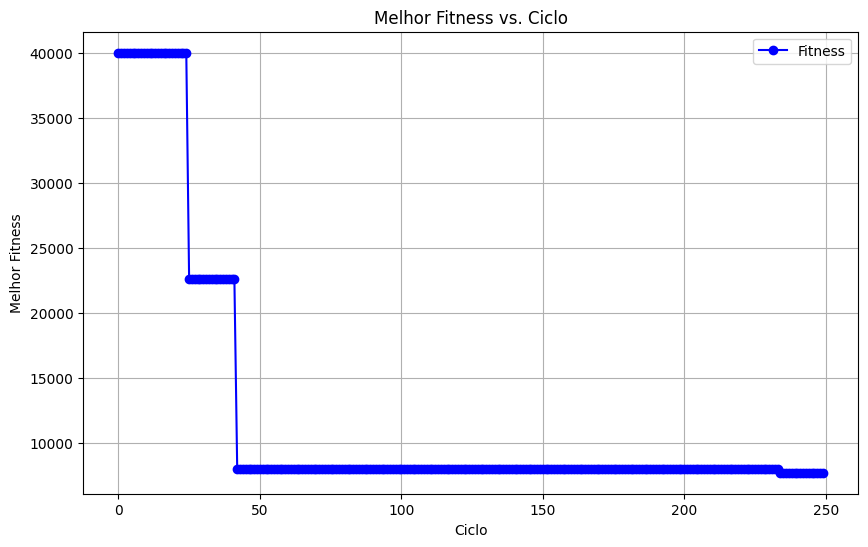

In [32]:
aca0 = AlgoritmoColoniaAbelhas(funcao=rosenbrock, limite_inferior=-5.12, limite_superior=5.12, qtd_ciclos=250, tamanho_colonia=30, dimensao=10, fator_abandono=8)
aca0.realizar_ciclo()
aca0.plotar_grafico_convergencia()

Geração 1 | Melhor solução: [ -5.6769959   43.23818251  22.90563728  -0.45616938 -13.29460615
 -35.9588911  -94.37129243  17.71172571 -24.5897653  -66.30610576] | Fitness: 18117.23570256206 | Histórico Fitness: [18117.23570256206]
Geração 100 | Melhor solução: [ 42.54254851 -56.10118136  30.06954319  -2.05344011  -5.15180202
   5.79006087  62.33848263 -28.63136479   3.48824728 -31.97785566] | Fitness: 11666.263483643885 | Histórico Fitness: [18117.23570256206, 18117.23570256206, 18117.23570256206, 18117.23570256206, 16215.756004964574, 16215.756004964574, 16215.756004964574, 16215.756004964574, 16215.756004964574, 16215.756004964574, 16215.756004964574, 16215.756004964574, 16215.756004964574, 16215.756004964574, 16215.756004964574, 11666.263483643885, 11666.263483643885, 11666.263483643885, 11666.263483643885, 11666.263483643885, 11666.263483643885, 11666.263483643885, 11666.263483643885, 11666.263483643885, 11666.263483643885, 11666.263483643885, 11666.263483643885, 11666.263483643885

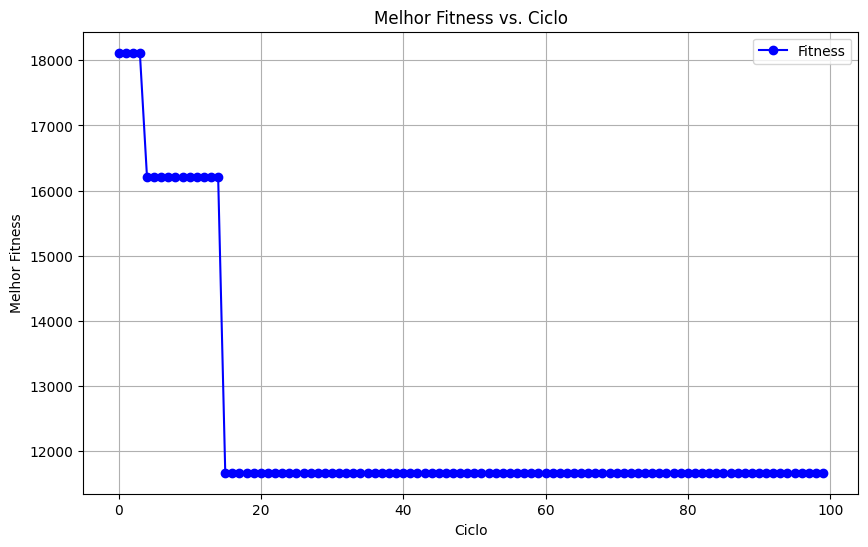

Geração 1 | Melhor solução: [ 85.07045386 -74.14981193  44.43818677 -17.16175283 -31.69575129
  63.16547638  15.67162686   0.52633701  35.66242177  63.83344911] | Fitness: 25591.347459705867 | Histórico Fitness: [25591.347459705867]
Geração 1000 | Melhor solução: [ -9.69653715  -8.599946     1.85205963  28.49799896 -19.55328269
 -46.28277496 -31.04748981 -16.24857707 -19.00242171  19.20853336] | Fitness: 5465.996760519504 | Histórico Fitness: [25591.347459705867, 25591.347459705867, 14233.330660901493, 14233.330660901493, 14233.330660901493, 14233.330660901493, 14233.330660901493, 14233.330660901493, 14233.330660901493, 14233.330660901493, 14233.330660901493, 14233.330660901493, 14233.330660901493, 14233.330660901493, 14233.330660901493, 14233.330660901493, 14233.330660901493, 14233.330660901493, 14233.330660901493, 14233.330660901493, 14233.330660901493, 14233.330660901493, 14233.330660901493, 14233.330660901493, 14233.330660901493, 14233.330660901493, 14233.330660901493, 14233.330660

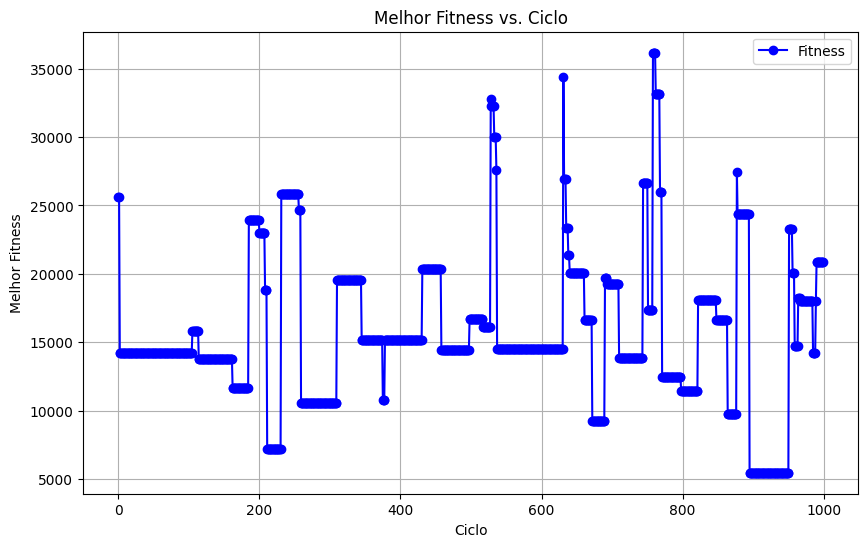

Geração 1 | Melhor solução: [-18.25552069   4.76789038   8.77469557  -2.64318334  65.09252697
  70.63115611  28.29112918  55.05195694  -5.37528527  33.13871272] | Fitness: 14623.949721449848 | Histórico Fitness: [14623.949721449848]
Geração 250 | Melhor solução: [ 28.9155478    1.54737577  55.95336566 -29.14103941   2.14802578
  -0.57759321 -17.65778166 -15.57354875  13.60274976  51.35768621] | Fitness: 8200.409620105325 | Histórico Fitness: [14623.949721449848, 14623.949721449848, 14623.949721449848, 14623.949721449848, 14623.949721449848, 14623.949721449848, 14623.949721449848, 14623.949721449848, 14623.949721449848, 14623.949721449848, 14623.949721449848, 14623.949721449848, 14623.949721449848, 14623.949721449848, 14623.949721449848, 14623.949721449848, 14623.949721449848, 14623.949721449848, 14623.949721449848, 13450.46730455295, 13450.46730455295, 13393.84575753525, 13393.84575753525, 13393.84575753525, 12901.96309649409, 12901.96309649409, 12901.96309649409, 12901.96309649409, 12

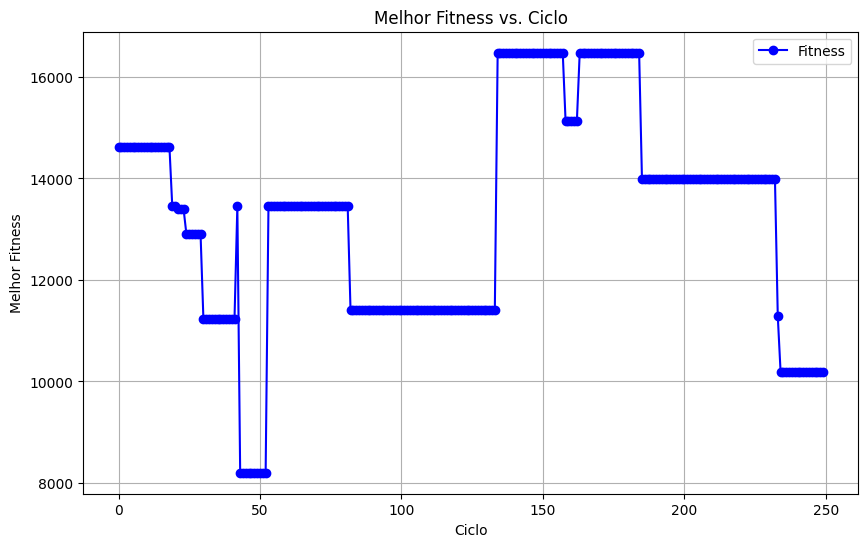

Geração 1 | Melhor solução: [-35.09748509  58.75983215   1.53718119  43.15221256   2.38957578
 -69.63618087  32.12801327 -31.15779777  -5.99193635  63.42738581] | Fitness: 17465.889635822023 | Histórico Fitness: [17465.889635822023]
Geração 50 | Melhor solução: [-38.20737647  41.80448813  56.16023782   1.70728707  48.12917579
  13.17992972 -11.38824582 -26.49178112 -31.79441032  26.9577027 ] | Fitness: 11423.542967330612 | Histórico Fitness: [17465.889635822023, 17465.889635822023, 17465.889635822023, 17465.889635822023, 17465.889635822023, 17465.889635822023, 17465.889635822023, 17465.889635822023, 17465.889635822023, 17465.889635822023, 17465.889635822023, 17465.889635822023, 17465.889635822023, 17465.889635822023, 17465.889635822023, 17465.889635822023, 11423.542967330612, 11423.542967330612, 11423.542967330612, 11423.542967330612, 11423.542967330612, 11423.542967330612, 11423.542967330612, 11423.542967330612, 11423.542967330612, 11423.542967330612, 11423.542967330612, 11423.5429673

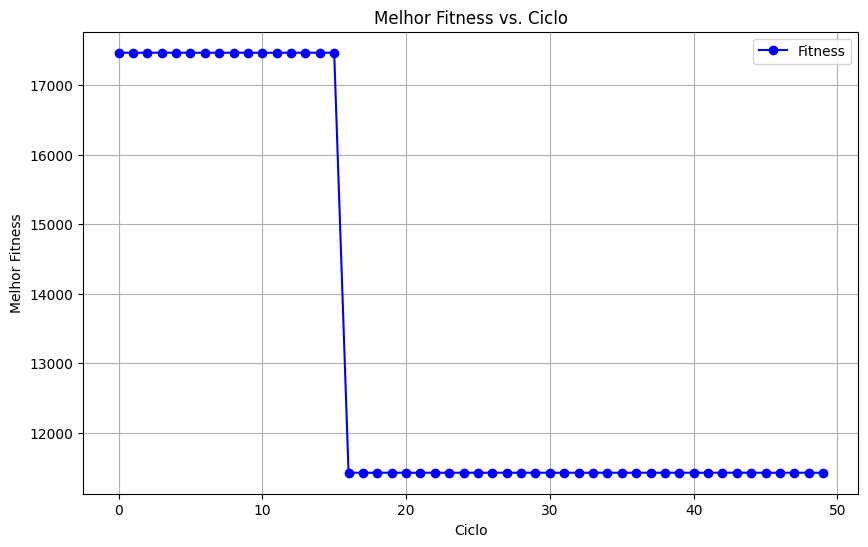

Geração 1 | Melhor solução: [ 90.3989219    5.12311974 -39.0192062  -29.42526017  20.6585523
 -42.93905103 -53.48922067   2.4111811   91.54654203   1.72031613] | Fitness: 24107.733078810867 | Histórico Fitness: [24107.733078810867]
Geração 500 | Melhor solução: [-68.25521202   9.73394733  33.8972584   83.37379979  15.4378959
  20.41719412  38.73509991 -22.46942051   9.84133789  15.90067257] | Fitness: 15863.894905742243 | Histórico Fitness: [24107.733078810867, 24107.733078810867, 24107.733078810867, 24107.733078810867, 24107.733078810867, 24107.733078810867, 24107.733078810867, 17719.058437696385, 17719.058437696385, 17719.058437696385, 17719.058437696385, 17719.058437696385, 17719.058437696385, 17719.058437696385, 17719.058437696385, 17719.058437696385, 17719.058437696385, 17719.058437696385, 17719.058437696385, 17719.058437696385, 17719.058437696385, 17719.058437696385, 17719.058437696385, 17719.058437696385, 17719.058437696385, 17719.058437696385, 17719.058437696385, 17719.05843769

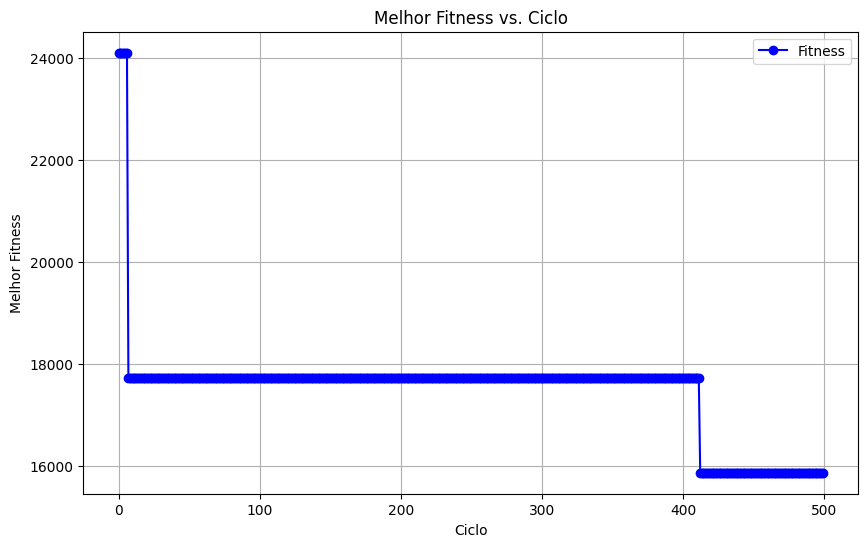

C:\Users\Pedro\AppData\Local\Temp\ipykernel_23692\2710037826.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(dados, labels=['Cenário 1', 'Cenário 2', 'Cenário 3', 'Cenário 4', 'Cenário 5'])


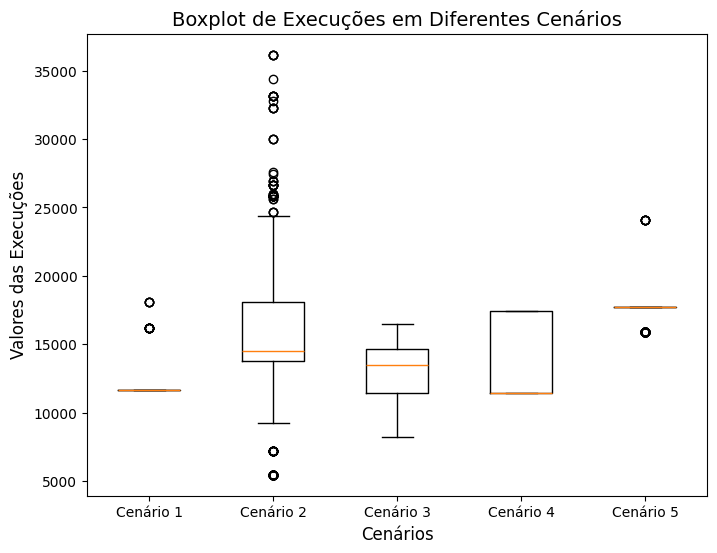

In [38]:
aca1 = AlgoritmoColoniaAbelhas(funcao=sphere, limite_inferior=-100, limite_superior=100, qtd_ciclos=100, tamanho_colonia=50, dimensao=10, fator_abandono=8)
aca1.realizar_ciclo()
aca1.plotar_grafico_convergencia()

aca2 = AlgoritmoColoniaAbelhas(funcao=sphere, limite_inferior=-100, limite_superior=100, qtd_ciclos=1000, tamanho_colonia=10, dimensao=10, fator_abandono=5)
aca2.realizar_ciclo()
aca2.plotar_grafico_convergencia()

aca3 = AlgoritmoColoniaAbelhas(funcao=sphere, limite_inferior=-100, limite_superior=100, qtd_ciclos=250, tamanho_colonia=30, dimensao=10, fator_abandono=3)
aca3.realizar_ciclo()
aca3.plotar_grafico_convergencia()

aca4 = AlgoritmoColoniaAbelhas(funcao=sphere, limite_inferior=-100, limite_superior=100, qtd_ciclos=50, tamanho_colonia=40, dimensao=10, fator_abandono=10)
aca4.realizar_ciclo()
aca4.plotar_grafico_convergencia()

aca5 = AlgoritmoColoniaAbelhas(funcao=sphere, limite_inferior=-100, limite_superior=100, qtd_ciclos=500, tamanho_colonia=15, dimensao=10, fator_abandono=15)
aca5.realizar_ciclo()
aca5.plotar_grafico_convergencia()

cenario_1 = aca1.historico_fitness
cenario_2 = aca2.historico_fitness
cenario_3 = aca3.historico_fitness
cenario_4 = aca4.historico_fitness
cenario_5 = aca5.historico_fitness

dados = [cenario_1, cenario_2, cenario_3, cenario_4, cenario_5]

# Criando o boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(dados, labels=['Cenário 1', 'Cenário 2', 'Cenário 3', 'Cenário 4', 'Cenário 5'])

# Adicionando título e rótulos aos eixos
plt.title('Boxplot de Execuções em Diferentes Cenários', fontsize=14)
plt.xlabel('Cenários', fontsize=12)
plt.ylabel('Valores das Execuções', fontsize=12)

# Mostrando o gráfico
plt.show()